# Table of content
1. [Importing relevent libraries](#01)
2. [Loading Dataset](#02)
3. [Distributions](#03)
    - [Age Distribution](#3.1)
    - [Ethnicity Distribution](#3.2)
    - [Gender Distribution](#3.3)
    - [Gender Distribution](#3.3)
    - [Sample Images](#3.4)
4. [Model for Gender Prediction](#04)
    - [Spliting data into train/test](#4.1)
    - [Build and train model](#4.2)
    - [Evaluating training history](#4.3)
5. [Model for Ethnicity Prediction](#05)
    - [Spliting data into train/test](#5.1)
    - [Build and train model](#5.2)
    - [Evaluating training history](#5.3)
6. [Model for Age Prediction](#06)
    - [Spliting data into train/test](#6.1)
    - [Build and train model](#6.2)
    - [Evaluating training history](#6.3)

## Importing relevent libraries <a id="01"></a>

In [17]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

In [18]:
data = pd.read_csv('age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [19]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


## Distributions <a id="03"></a>

In [20]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Age Distribtion <a id="3.1"></a>

In [21]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Ethnicity Distribution <a id="3.2"></a>

In [22]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender Distribution <a id="3.3"></a>

In [23]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [24]:
X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

### Sample Images <a id="3.4"></a>

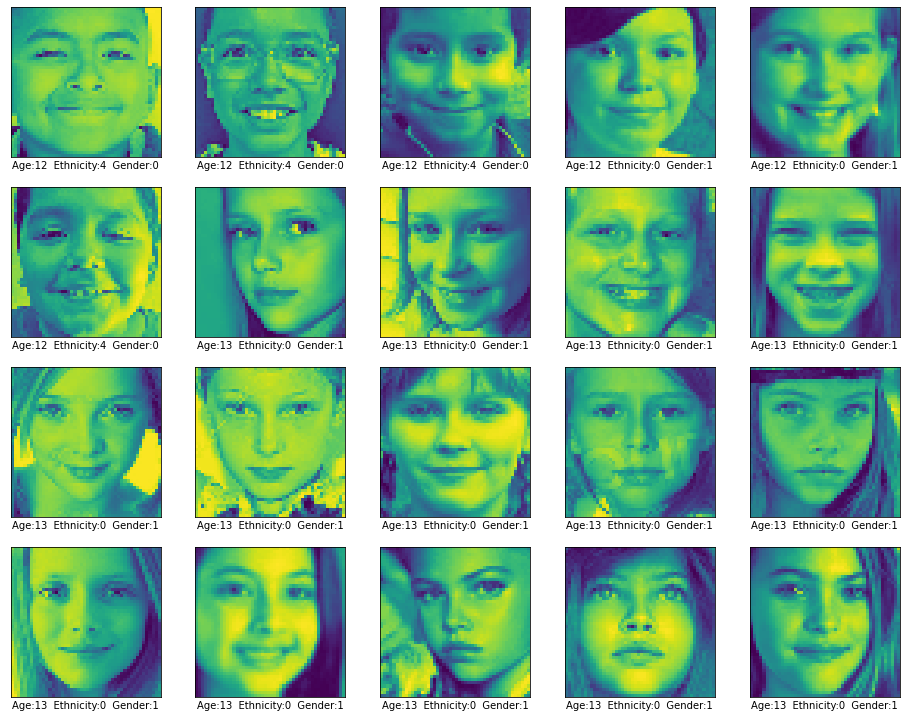

In [25]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

 <a id="04"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Gender Prediction</center>
</h1>

### Split data into train/test <a id="4.1"></a>

In [26]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="4.2"></a>

In [27]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [28]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 35s 135ms/step - loss: 0.5884 - accuracy: 0.6797 - val_loss: 0.5954 - val_accuracy: 0.8183
Epoch 2/20
260/260 [==============================] - 37s 141ms/step - loss: 0.4073 - accuracy: 0.8142 - val_loss: 0.4024 - val_accuracy: 0.8394
Epoch 3/20
260/260 [==============================] - 36s 140ms/step - loss: 0.3537 - accuracy: 0.8411 - val_loss: 0.3442 - val_accuracy: 0.8480
Epoch 4/20
260/260 [==============================] - 36s 140ms/step - loss: 0.3414 - accuracy: 0.8476 - val_loss: 0.3233 - val_accuracy: 0.8621
Epoch 5/20
260/260 [==============================] - 37s 142ms/step - loss: 0.3152 - accuracy: 0.8598 - val_loss: 0.3110 - val_accuracy: 0.8643
Epoch 6/20
260/260 [==============================] - 37s 143ms/step - loss: 0.3116 - accuracy: 0.8609 - val_loss: 0.3018 - val_accuracy: 0.8675
Epoch 7/20
260/260 [==============================] - 37s 142ms/step - loss: 0.2898 - accuracy: 0.8731 - val_loss: 0.3070 - val_ac

### Evaluate training history <a id="4.3"></a>

In [29]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [30]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.2593406140804291
Test Accuracy: 0.8842024803161621


<a id="05"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Ethnicity Prediction</center>
</h1>

### Split data into train/test <a id="5.1"></a>

In [31]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="5.2"></a>

In [32]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [33]:
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/16
260/260 [==============================] - 25s 94ms/step - loss: 1.4183 - accuracy: 0.4439 - val_loss: 1.0852 - val_accuracy: 0.5727
Epoch 2/16
260/260 [==============================] - 24s 94ms/step - loss: 1.0608 - accuracy: 0.6163 - val_loss: 0.8285 - val_accuracy: 0.7177
Epoch 3/16
260/260 [==============================] - 24s 93ms/step - loss: 0.9359 - accuracy: 0.6707 - val_loss: 0.8182 - val_accuracy: 0.7296
Epoch 4/16
260/260 [==============================] - 24s 93ms/step - loss: 0.8746 - accuracy: 0.6918 - val_loss: 0.7142 - val_accuracy: 0.7501
Epoch 5/16
260/260 [==============================] - 24s 94ms/step - loss: 0.8168 - accuracy: 0.7146 - val_loss: 0.7070 - val_accuracy: 0.7480
Epoch 6/16
260/260 [==============================] - 24s 93ms/step - loss: 0.7923 - accuracy: 0.7247 - val_loss: 0.6690 - val_accuracy: 0.7658
Epoch 7/16
260/260 [==============================] - 24s 93ms/step - loss: 0.7726 - accuracy: 0.7323 - val_loss: 0.6973 - val_accuracy:

### Evaluate training history <a id="5.3"></a>

In [34]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [35]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6275880336761475
Test Accuracy: 0.7841257452964783


<a id="06"></a>

<h1 class="list-group-item active" style='background:orange; border:0'>
    <center>Model for Age prediction</center>
</h1>

### Split data into train/test <a id="6.1"></a>

In [36]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [37]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)        

In [38]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 39s 149ms/step - loss: 479.8226 - mae: 16.7172 - val_loss: 1200.0939 - val_mae: 28.9465
Epoch 2/20
260/260 [==============================] - 41s 158ms/step - loss: 221.9805 - mae: 11.2584 - val_loss: 485.0368 - val_mae: 16.9480
Epoch 3/20
260/260 [==============================] - 41s 156ms/step - loss: 181.7875 - mae: 10.1458 - val_loss: 133.2316 - val_mae: 8.3923
Epoch 4/20
260/260 [==============================] - 41s 158ms/step - loss: 165.0134 - mae: 9.6002 - val_loss: 111.7237 - val_mae: 7.8290
Epoch 5/20
260/260 [==============================] - 41s 156ms/step - loss: 148.7807 - mae: 8.9815 - val_loss: 187.2439 - val_mae: 10.8634
Epoch 6/20
260/260 [==============================] - 41s 157ms/step - loss: 133.5871 - mae: 8.5471 - val_loss: 117.8403 - val_mae: 8.2489
Epoch 7/20
260/260 [==============================] - 41s 159ms/step - loss: 129.6332 - mae: 8.4408 - val_loss: 124.2200 - val_mae: 8.1471
Epoch 8/20
260/260 [

### Evaluate training history <a id="6.3"></a> 

In [39]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [40]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 99.17769622802734
Test Mean absolute error: 7.221635341644287


![Alt Text](https://www.kudos.com/assets/Blog/b5843aa89b/thankyou__FillWzcwMCw0NDBd.jpg)